In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# To fix https://github.com/bstriner/keras-tqdm/issues/21#issuecomment-443019223

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [8]:

from pytorch_utils.imports import *
from pytorch_utils.hooks import Hook
from pytorch_utils.callbacks import MyLrFinder, RecordMetric
from pytorch_utils.trainer import learn, Interpretration
from pytorch_utils.utils import show_batch, plot_confusion_matrix
from pytorch_utils.model_utils import transfer_learning_model, model_summary

import sys

In [9]:
assert(torch.__version__ == '1.2.0+cu92')
assert(torchvision.__version__== '0.4.0+cu92')
assert(sys.version[:5] == '3.7.0')

import warnings
warnings.filterwarnings('ignore')

AssertionError: 

In [4]:
# %load ../Data/data.py


from torchvision import models, transforms

## Create new class definitions for
#- loading data from Image folder (class1, class2, class3...) with optional subset of classes
#- split data into train and val subsets

from torch.utils.data import Dataset
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS, make_dataset, pil_loader

class ImageFolderWithClassSubset(DatasetFolder):
    '''
    Custom Dataset from ImageFolder with subset of classes defined by classes_for_consideration.
    If classes_for_consideration = None, then all classes are choosen.
    '''
    def __init__(self, root, classes_subset = None):
        super().__init__(root, loader = pil_loader, extensions = IMG_EXTENSIONS)
        if classes_subset:
           # check if the classes in classes_subset are part of available classes deteced by DatasetFolder in the root folder
            if all([_ in self.classes for _ in classes_subset]):
                classes, class_to_idx = classes_subset, {classes_subset[i]: i for i in range(len(classes_subset))}
                samples = make_dataset(self.root, class_to_idx, extensions = IMG_EXTENSIONS)
                self.classes = classes
                self.class_to_idx = class_to_idx
                self.samples = samples
                self.targets = [s[1] for s in samples]
            else:
                print("Certain Class in classes_subset is not available in possible classes. Check your classes_subset. Choosing all classes instead")

class TrainValSubsets(Dataset):
    '''
    Subset a dataset based on indices
    '''
    def __init__(self, dataset, indices, transforms = None):
        self.subset = dataset
        self.indices = indices
        self.transforms = transforms
        
        if not self.transforms:
            self.transforms  = transforms.Compose([transforms.ToTensor()])
        else:
            self.transforms  = transforms
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.subset[self.indices[idx]]
        return (self.transforms(sample[0]), sample[1])
    
## Load all data 

data_root= Path('../Data')
all_data = ImageFolderWithClassSubset(root=data_root, classes_subset=['arts_and_crafts', 'mid-century-modern', 'rustic', 'traditional'])
print(all_data)
print(f"Classes: {all_data.classes}")
print(f"Class Mapping: {all_data.class_to_idx}")

## Create indices for train and val data based on ranom split on whole dataset

#Create random split and create indices for train and val
idx = {}
# torch.manual_seed(1)
rand_idx = torch.randperm(len(all_data))
val_pct = .2
split = int(val_pct*len(rand_idx))
idx['val'] = rand_idx[:split]
idx['train'] = rand_idx[split:]

## Define Transforms on train and val data 


imagenet_stats  = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

trfms = {}
trfms['train'] = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(10),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*imagenet_stats)])

trfms['val'] = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*imagenet_stats)])


## Create Train and val  datasets and dataloaders

datasets = {}  # Holds datasets
dataloaders = {} # Holds dataloaders
BATCH_SIZE = 32

for datatype in ['train','val']:

    # Dataset
    datasets[datatype] = TrainValSubsets(all_data, idx[datatype],  transforms = trfms[datatype])
    
    # Dataloader
    dataloaders[datatype] = torch.utils.data.DataLoader(datasets[datatype], BATCH_SIZE, num_workers=4, shuffle = True)

## Define a data dict that holds dataloaders, datasets, mappings, transforms, normalizing stats etc.

data = {}
data['norm_stats'] = imagenet_stats
data['ds'] = datasets
data['dl'] = dataloaders
data['classes'] = all_data.classes
data['tfms'] = trfms
data['maping'] = all_data.class_to_idx

# lets check the size of the train image dataset
print(f"Train size: {len(data['ds']['train'])}")

#Test the frist image on val image_dataset
print(f"Val size: {len(data['ds']['val'])}")


Dataset ImageFolderWithClassSubset
    Number of datapoints: 624
    Root location: ../Data
Classes: ['arts_and_crafts', 'mid-century-modern', 'rustic', 'traditional']
Class Mapping: {'arts_and_crafts': 0, 'mid-century-modern': 1, 'rustic': 2, 'traditional': 3}
Train size: 500
Val size: 124


## Visualize a batch



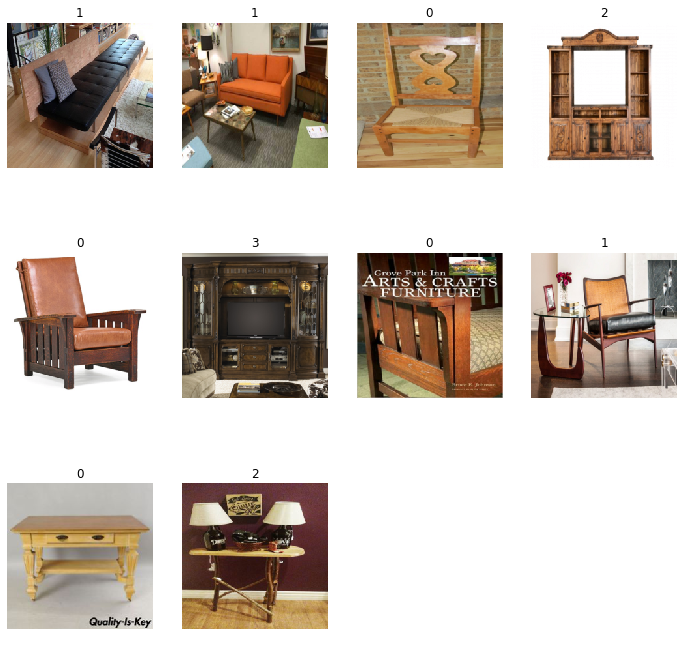

In [5]:
show_batch(data['dl']['val'], classes = data['classes'], normalize_stats=imagenet_stats, plot_num=10)

## Define a transfer learning model by cropping a full model and adding pooling layers, flattening layers and FC layers

### Find the LR 

In [6]:
net = transfer_learning_model(models.resnet34(pretrained = True), number_classes= len(data['classes']), 
                              resnet_dummy_img_batch=torch.rand(1,3,224,224))
model_summary(net,dummy_batch = torch.rand(1,3,224,224) )

Input: torch.Size([1, 3, 224, 224])
--------------------------------------------------
CONV1
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 3, 224, 224])
Parameters
weight: torch.Size([64, 3, 7, 7])
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
BN1
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
Parameters
weight: torch.Size([64])
bias: torch.Size([64])
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
RELU
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
No Parameters
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
MAXPOOL
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
No Parameters
OUTPUT SHAPE: torch.Size([1, 64, 56, 56])
--------------------------------------------------
LAYER

In [7]:
net = transfer_learning_model(models.resnet34(pretrained = True), number_classes= len(data['classes']), 
                              resnet_dummy_img_batch=torch.rand(1,3,224,224))

from torch import optim, nn
optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9, weight_decay=1e-4, nesterov=True)    
#optimizer = optim.Adam(net.parameters(), lr=6E-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer, criterion, checkpoint_source='../Checkpoints/checkpoint.pth')
testlearner.unfreeze(num_layers=5)
epochs = 5
iterations_per_epoch = len(testlearner.data['dl']['train'])
stepsize = 4 * iterations_per_epoch

Loading model from ../Checkpoints/checkpoint.pth


Epoch:17 | train Loss: 0.56 | Metric : 78.438
Epoch:17 | val Loss: 0.42 | Metric : 85.379
Saving to ../Checkpoints/checkpoint.pth
-------------------------


Epoch:18 | train Loss: 0.58 | Metric : 79.180
Epoch:18 | val Loss: 0.43 | Metric : 80.469
-------------------------


Epoch:19 | train Loss: 0.59 | Metric : 77.031
Epoch:19 | val Loss: 0.45 | Metric : 80.692
-------------------------


Epoch:20 | train Loss: 0.55 | Metric : 78.281
Epoch:20 | val Loss: 0.47 | Metric : 82.254
-------------------------


Epoch:21 | train Loss: 0.54 | Metric : 78.984
Epoch:21 | val Loss: 0.62 | Metric : 77.679
-------------------------


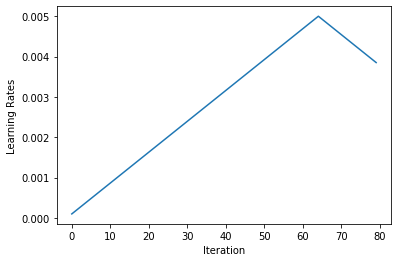

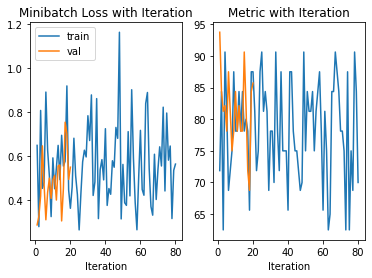

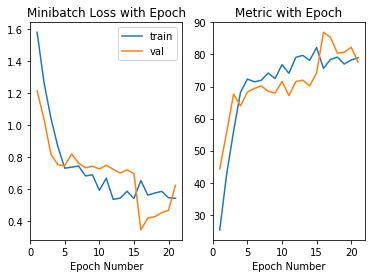

In [10]:

testlearner.cyclic_lr(epochs, 1E-4, 0.5E-2, stepsize, policy = 'triangular')

In [11]:
interp = Interpretration.from_learner(testlearner, data)

dict_keys(['preds', 'gt', 'probs', 'losses', 'all_inputs'])


array([ 8,  1,  2,  0,  3,  4, 10,  6,  5, 11,  9,  7])

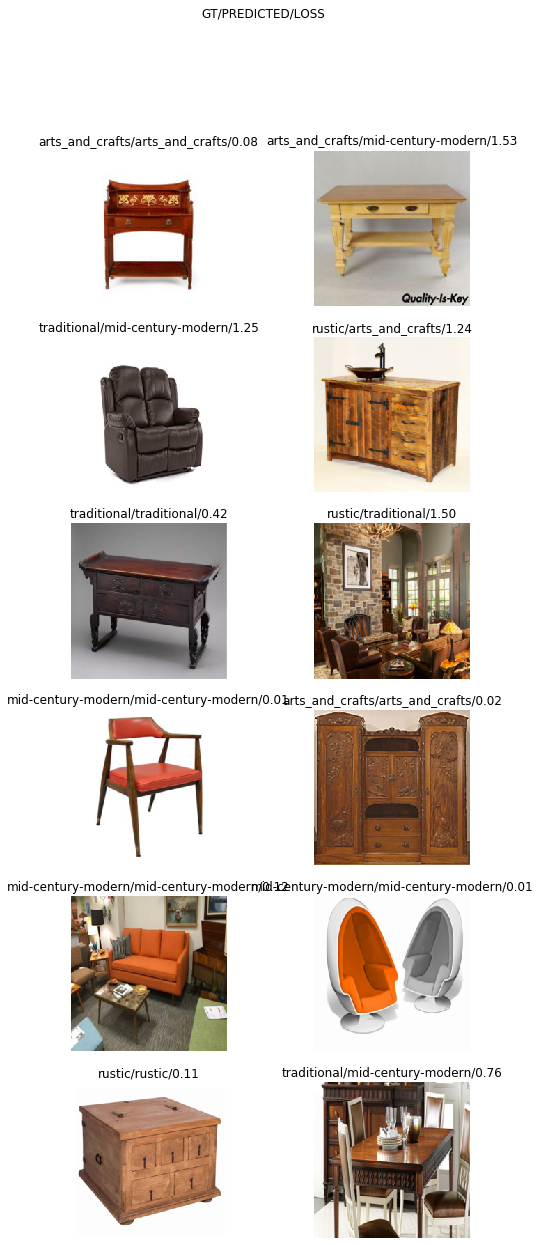

In [12]:
interp.top_N_losses(plot=True)

In [13]:
plot_confusion_matrix(y_true = inference_data['gt'],y_pred = inference_data['preds'], classes= data['classes'])

NameError: name 'inference_data' is not defined

In [14]:
from torchvision import models
net = transfer_learning_model(model_original=models.resnet34(pretrained = False),
                              number_classes=4)

In [17]:
checkpoint = torch.load('../Checkpoints/checkpoint.pth',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model'])


<All keys matched successfully>

In [180]:
infer_data = data['ds']['val']

inp, label = infer_data[torch.randint(low = 0, high = len(infer_data), size = (1,)).item()] # Pick One random  
net.eval()

with Hook(net.layer4) as hook:
    logit = net(inp.unsqueeze_(dim=0))
    
out = F.softmax(logit, dim=1).squeeze()

probs, idxs = out.sort(descending=True)

print(f"Actual Class : {data['classes'][label]}")
print("Label: Probability")  
for label, prob in zip([data['classes'][i] for i in idxs], probs):
    print(f"{label} -> {prob.item():.3f}")      

Actual Class : mid-century-modern
Label: Probability
mid-century-modern -> 0.810
traditional -> 0.155
rustic -> 0.030
arts_and_crafts -> 0.005


In [ ]:
net.eval()
